In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# # Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install torchsummary

In [4]:
import torch
from torch.utils.data import Dataset, Subset, SubsetRandomSampler, SequentialSampler
from torch.utils.data.dataset import TensorDataset
from torch.distributions.multivariate_normal import MultivariateNormal
import torch.nn.functional as F
from torch_geometric.data import DataLoader
from torch_geometric.data import Data
from torch_geometric.utils.convert import to_networkx
torch.manual_seed(0)

import networkx as nx # for visualizing graphs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pdb
from torchsummary import summary
import json
import pickle
import os

from functions.load_data import MarielDataset, edges
from functions.functions import *
from functions.modules import *
from functions.seq_autoencoder import *

# Test

In [5]:
! ls ./logs/

nri
nri_gpu_noskip
nri_gpu_skip
nri_gpu_skip_seq49
nri_gpu_skip_shorttest
nri_k2_pred0_53joints_seqlen49_pred0
nri_k2_pred10_53joints_seqlen49_pred10
nri_k4_pred0_53joints_seqlen49_pred0
nri_k4_pred10_53joints_seqlen49_pred10
nri_skip_tiny_seq2
test
test_seq49
vae_53joints_seqlen49_pred0
vae_nosampling_norecurrent_53joints_seqlen49_pred0
vae_nosampling_recurrent_53joints_seqlen49_pred0
vae_sampling_norecurrent_53joints_seqlen49_pred0
vae_sampling_recurrent_53joints_seqlen49_pred0


In [6]:
folder = "./logs/test_seq49"
dataloader_test = torch.load(os.path.join(folder,"dataloader_test.pth"))
dataloader_train = torch.load(os.path.join(folder,"dataloader_train.pth"))
checkpoint_path = os.path.join(folder,"best_weights.pth")
args_file = os.path.join(folder, 'args.pkl')
args = pickle.load(open(args_file, "rb" ))['args']
checkpoint_loaded = False 

# Load these if training actually completed:
if os.path.exists(os.path.join(folder,"losses.json")):
    print("Loaded losses")
    dict = json.load(open(os.path.join(folder,"losses.json")))
    train_losses = dict['train_losses']
    val_losses = dict['val_losses']

Loaded losses


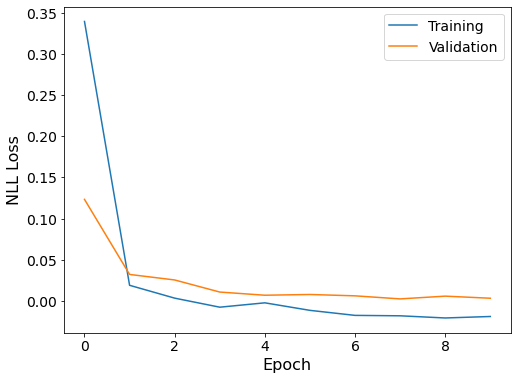

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.arange(len(train_losses)), train_losses, label="Training")
ax.plot(np.arange(len(val_losses)), val_losses, label="Validation")
ax.set_xlabel("Epoch", fontsize=16)
ax.set_ylabel("NLL Loss", fontsize=16)
# ax.set_yscale("log")
# ax.set_ylim(-0.05,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.legend(fontsize=14)

In [8]:
if torch.cuda.is_available() and args.no_cuda == False:
    device = torch.device('cuda')
else:
    device = 'cpu'

model = NRI(device=device,
            node_features=args.seq_len*6, 
            edge_features=args.seq_len, 
            hidden_size=args.hidden_size, 
            node_embedding_dim=args.node_embedding_dim,
            edge_embedding_dim=args.edge_embedding_dim,
            skip_connection=args.skip_connection,
            dynamic_graph=args.dynamic_graph,
            seq_len=args.seq_len,
           )

optimizer = torch.optim.Adam(list(model.parameters()), lr=args.lr, weight_decay=5e-4)

print("Using {}".format(device))
model = model.to(device)
print(model)
print("Total trainable parameters: {:,}".format(count_parameters(model)))

Using cuda
NRI(
  (encoder): NRIEncoder(
    (node_embedding_eqn_5): Sequential(
      (0): Linear(in_features=294, out_features=36, bias=True)
      (1): ReLU()
    )
    (mlp_eqn_6): Sequential(
      (0): Linear(in_features=72, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=36, bias=True)
    )
    (mlp_eqn_7): Sequential(
      (0): Linear(in_features=36, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=36, bias=True)
    )
    (mlp_eqn_8): Sequential(
      (0): Linear(in_features=144, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=4, bias=True)
    )
    (graph_conv): NRIGraphConv(36, 36)
  )
  (decoder): NRIDecoder(
    (encoder): NRIEncoder(
      (node_embedding_eqn_5): Sequential(
        (0): Linear(in_features=294, out_features=36, bias=True)
        (1): ReLU()
      )
      (mlp_eqn_6): Sequential(
        (0): Linear(in_features=72

In [9]:
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss_checkpoint = checkpoint['loss']
checkpoint_loaded = True
n_joints = 53

In [10]:
def test(batch_limit=0):
    mse_loss = torch.nn.MSELoss(reduction='mean')
    prediction_to_reconstruction_loss_ratio = 1 # CHANGE THIS TO ARGS
    total_test_loss = 0
    total_test_reco_loss = 0
    total_test_pred_loss = 0
    n_batches = 0
    actuals = []
    preds = []
    model.eval()
    for batch in tqdm(dataloader_test, desc="Test batches"):
        batch = batch.to(device)

        ### CALCULATE MODEL OUTPUTS
        output, edges = model(batch)
        
        ### SAVE FOR ANIMATIONS
        actuals.append(batch.x.detach().cpu().numpy())
        preds.append(output.detach().cpu().numpy())

        ### CALCULATE LOSS
        test_loss = mse_loss(batch.x.to(device), output) # compare first seq_len timesteps

        ### ADD LOSSES TO TOTALS
        total_test_loss += test_loss.item()
            
        ### OPTIONAL -- STOP TESTING EARLY
        n_batches += 1
        if (batch_limit > 0) and (n_batches >= batch_limit): break # temporary -- for stopping training early

    ### CALCULATE AVERAGE LOSSES PER EPOCH   
    average_test_loss = total_test_loss / n_batches
    print("Loss = {:,.8f}".format(average_test_loss))
    return actuals, preds

In [11]:
actuals, preds = test(batch_limit = 20)

Test batches:   4%|▍         | 19/478 [00:37<15:13,  1.99s/it]

Loss = 0.00000103


In [13]:
batch_number = 0
truth_sequences= []
predicted_sequences = []

for seq_number in np.arange(args.batch_size):
    actual = actuals[batch_number][seq_number*n_joints:seq_number*n_joints+n_joints].reshape((n_joints,args.seq_len,6))[:,:,:3] # take the first 3 dimensions for positions, not velocities
    pred = preds[batch_number][seq_number*n_joints:seq_number*n_joints+n_joints].reshape((n_joints,args.seq_len,6))[:,:,:3]
    actual = np.transpose(actual, [1,0,2])
    pred = np.transpose(pred, [1,0,2])
    truth_sequences.append(actual)
    predicted_sequences.append(pred)
    
truth_sequences = np.asarray(truth_sequences).reshape((args.batch_size*args.seq_len, n_joints, 3))
predicted_sequences = np.asarray(predicted_sequences).reshape((args.batch_size*args.seq_len, n_joints, 3))

start_index = 0
# timesteps = args.seq_len*args.batch_size
timesteps = args.seq_len
animation = animate_stick(truth_sequences[start_index:start_index+timesteps,:,:], 
                          ghost=predicted_sequences[start_index:start_index+timesteps,:,:], 
                          ghost_shift=0.4,
                          ax_lims = (-0.7,0.7),
                          figsize=(10,8), cmap='inferno')
HTML(animation.to_html5_video())

Skeleton lines: 100%|██████████| 74/74 [00:00<00:00, 435.63it/s]


In [ ]:
# sampling_recurrent = [0.0969,0.0103,0.0100,0.0067,0.0066,0.0063,0.0056,0.0051,0.0042,0.0041,0.0048,0.0027,0.0016,0.0037,0.0038,0.0031,0.0036,0.0017,0.0016,0.0041,0.0089,]
# nosampling_recurrent = [0.6768,0.3889,0.0499,0.0085,0.0081,0.0079,0.0080,0.4788,0.0412,0.1520,0.0554,0.0090,0.0088,0.0088,0.0088,223.3473,0.0089,0.0186,0.0092,0.0089,0.0093,]
# sampling_norecurrent = [6,419,004.4403,1,180,173.9217,12,472.5292,5,309.1666,3,601.1410,23,310.8198,10,171,718.4292,0.0089,0.0089,0.0089,0.0089,0.0089,0.0089,0.0089,0.0089,0.0089,0.0089,0.0089,0.0089,962.9072,]
# nosampling_norecurrent = [16,822,800.1428,651,681.9966,187,729.5295,211,615.4727,334,911.2555,183,381.5607,28,994.0494,28,142.1309,28,039.8979,27,708.8960,26,805.5452,23,027.8847,10,154.9895,0.0089,0.0089,0.0089,0.0089,0.0089,0.0089,0.0089,]
# val_losses_moreparams = [1.2585,0.2413,0.2063,0.3304,0.1753,0.1665,0.1516,0.2043,0.1444,32.0709,0.1563,15.5246,0.7867,1.8139,2.1597,0.1700,0.1611,0.1606,0.1605,0.1671,0.1589,0.7795,0.1553,0.1550,0.1546,0.1544,0.1546,0.1546,0.1522,0.1533,0.1545,0.1509,0.1521,0.1538,0.1538,0.1467,0.1402,0.1433,0.1413,0.1402,0.1425,0.1419,0.1372,0.1359,0.1319,0.1331,0.1354,0.1371,0.1360,0.1283,0.1283,0.1277,0.1277,0.1271,0.1353,0.1353,0.1390,0.1249,0.0118,0.0040,0.1584,0.1568,0.1558,0.1556,0.1556,0.1554,0.1536,0.1535,0.1533,0.1523,0.1419,0.1338,]

In [ ]:
# fig, ax = plt.subplots(figsize=(8,6))
# # ax.plot(np.arange(len(val_losses)), val_losses, label="Graph VAE (250k params)")
# # ax.plot(np.arange(len(val_losses_moreparams)), val_losses_moreparams, label="Graph VAE (1.8M params)")
# # ax.plot(np.arange(len(sampling_recurrent)), sampling_recurrent, label="Sampling, Recurrent")
# # ax.plot(np.arange(len(nosampling_recurrent)), nosampling_recurrent, label="No Sampling, Recurrent")
# ax.plot(np.arange(len(sampling_norecurrent)), sampling_norecurrent, label="Sampling, No Recurrent")
# ax.plot(np.arange(len(nosampling_norecurrent)), nosampling_norecurrent, label="No Sampling, No Recurrent")
# ax.set_xlabel("Epoch", fontsize=16)
# ax.set_ylabel("Validation Reco Loss", fontsize=16)
# # ax.set_yscale("log")
# # ax.set_ylim(0,0.1)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# ax.legend(fontsize=14)

### Up next:
- Try to overfit the input data (loss = 0) by setting prediction weight = 0
- Weight the prediction loss to ensure that the most immediate steps are more important to reconstruct than far future steps (like 1/2^t or something)

### For later:
- The Gaussian negative log likelihood loss functions will only make sense when the output of the decoder is mu (eq'n 16 & 17)

### Done
- ~~Predict 50 + k timesteps w/ separate MSE losses~~
- ~~Look at VAE outputs!~~
- ~~Look at NRI outputs!~~